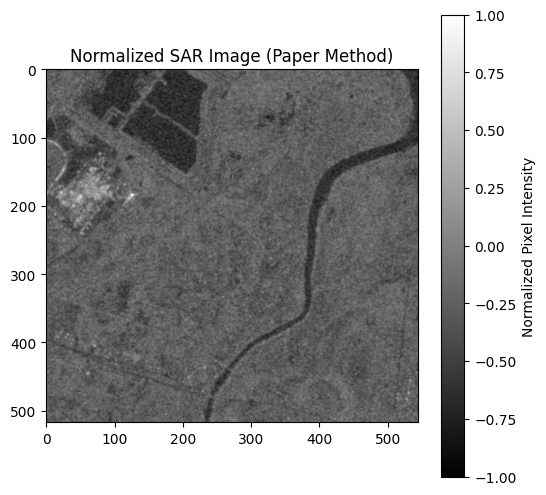

In [47]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load .tif file
tif_path = "/home/alex/Desktop/miniproject/VH.tif"

with rasterio.open(tif_path) as src:
    image = src.read(1).astype(np.float32)  # Read the first band

# Apply log transformation as per the paper
image = 10 * np.log10(image + 1e-6) + 50  

image = (image - np.min(image)) / (np.max(image) - np.min(image))  
image = (image * 2) - 1  

# Display image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap="gray")
plt.colorbar(label="Normalized Pixel Intensity")
plt.title("Normalized SAR Image (Paper Method)")
plt.show()


In [ ]:
import os
import random
import shutil

# Set the directories relative to the working directory
labels_dir = 'archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels'
source_dir = 'archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source'

# List and sort the label directories for reproducibility
label_dirs = sorted([d for d in os.listdir(labels_dir) if os.path.isdir(os.path.join(labels_dir, d))])

# Shuffle and select half of the directories to delete
random.shuffle(label_dirs)
num_to_delete = len(label_dirs) // 2
dirs_to_delete = label_dirs[:num_to_delete]

deleted_pairs = 0

for dirname in dirs_to_delete:
    label_path = os.path.join(labels_dir, dirname)
    # Replace label prefix with source prefix to form the corresponding source directory name
    source_dirname = dirname.replace("sen12floods_s1_labels", "sen12floods_s1_source", 1)
    source_path = os.path.join(source_dir, source_dirname)
    
    # Only delete if both the label and source directories exist
    if os.path.isdir(label_path) and os.path.isdir(source_path):
        shutil.rmtree(label_path)
        shutil.rmtree(source_path)
        deleted_pairs += 1
        print(f"Deleted pair: {label_path} and {source_path}")
    else:
        print(f"Skipping {dirname}: Pair not found (label exists: {os.path.isdir(label_path)}, source exists: {os.path.isdir(source_path)})")

print(f"Total deleted pairs: {deleted_pairs}")

In [19]:
remaining_pairs = 0
for dirname in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, dirname)
    if os.path.isdir(label_path):
        # Form the corresponding source directory name
        source_dirname = dirname.replace("sen12floods_s1_labels", "sen12floods_s1_source", 1)
        source_path = os.path.join(source_dir, source_dirname)
        if os.path.isdir(source_path):
            remaining_pairs += 1

print(f"Total remaining pairs: {remaining_pairs}")

Total remaining pairs: 104


In [ ]:
import os

source_dir = 'archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source'
deleted_count = 0

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file == 'VV.tif':
            file_path = os.path.join(root, file)
            os.remove(file_path)
            deleted_count += 1
            print(f"Deleted: {file_path}")

print(f"Total VV.tif files deleted: {deleted_count}")

In [18]:
import os
import json

labels_root = 'archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels'
flooding_true_count = 0
flooding_false_count = 0

# Iterate through each subdirectory in the labels root directory
for dir_name in os.listdir(labels_root):
    dir_path = os.path.join(labels_root, dir_name)
    if os.path.isdir(dir_path):
        labels_geojson_path = os.path.join(dir_path, 'labels.geojson')
        if os.path.exists(labels_geojson_path):
            with open(labels_geojson_path, 'r') as f:
                data = json.load(f)
                flooding = data.get("properties", {}).get("FLOODING")
                if flooding is True:
                    flooding_true_count += 1
                elif flooding is False:
                    flooding_false_count += 1
        else:
            print(f"File not found: {labels_geojson_path}")

print("Total labels with flooding true:", flooding_true_count)
print("Total labels with flooding false:", flooding_false_count)

Total labels with flooding true: 32
Total labels with flooding false: 72


In [1]:
import os
import torch
import numpy as np
import rasterio
import json
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class FloodDataset(Dataset):
    def __init__(self, source_dir, labels_dir, target_size=(512, 512), transform=None):
        self.source_dir = source_dir
        self.labels_dir = labels_dir
        self.target_size = target_size  # Fixed size for all images
        self.transform = transform
        
        # Get list of SAR image directories (sorted for consistency)
        self.sample_ids = sorted(os.listdir(source_dir))
        
    def __len__(self):
        return len(self.sample_ids)
    
    def preprocess_sar(self, image):
        """Apply log transformation and normalize to [-1,1]."""
        # Apply log transformation first
        image = 10 * np.log10(image + 1e-6) + 50  # Avoid log(0)
        
        # Compute denominator safely
        img_min = np.min(image)
        img_max = np.max(image)
        denom = img_max - img_min
        if denom < 1e-6:
            # If the image has no contrast, set it to zeros
            image = np.zeros_like(image)
        else:
            image = (image - img_min) / denom  # Normalize to [0,1]
        
        # Scale to [-1,1]
        image = (image * 2) - 1
        return image.astype(np.float32)

    
    def get_flood_label(self, label_path):
        """Read labels.geojson and return flood label (0 or 1)."""
        if not os.path.exists(label_path):
            print(f"Warning: Missing label file {label_path}")
            return 0  # Default to no flood if label is missing
        
        with open(label_path, "r") as f:
            label_data = json.load(f)
        return 1 if label_data["properties"].get("FLOODING", False) else 0
    
    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        sample_dir = os.path.join(self.source_dir, sample_id)
        
        # Find VH.tif within the sample directory (search recursively)
        vh_file = None
        for root, dirs, files in os.walk(sample_dir):
            if "VH.tif" in files:
                vh_file = os.path.join(root, "VH.tif")
                break
        if vh_file is None:
            raise FileNotFoundError(f"VH.tif not found in directory: {sample_dir}")
        image_path = vh_file
        
        # Construct label path by replacing source with labels in the directory name
        label_subdir = sample_id.replace("sen12floods_s1_source", "sen12floods_s1_labels")
        label_path = os.path.join(self.labels_dir, label_subdir, "labels.geojson")
        
        # Check if label file exists
        if not os.path.exists(label_path):
            print(f"Warning: Missing label for {sample_id}, skipping.")
            return self.__getitem__((idx + 1) % len(self.sample_ids))
        
        # Load SAR image
        with rasterio.open(image_path) as src:
            image = src.read(1).astype(np.float32)  # Read single-band VH SAR image
        image = self.preprocess_sar(image)
        
        # Convert the numpy array to a torch tensor and add channel dimension: (1, H, W)
        image = torch.tensor(image).unsqueeze(0)
        # Resize image to target size (batch stacking requires same size)
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        
        # Load flood label (global scalar label: 0 or 1)
        flood_label = self.get_flood_label(label_path)
        label = torch.tensor(flood_label, dtype=torch.float32)
        
        return image, label

# Example usage:
# Ensure these directories point to the folders that directly contain your sample subdirectories.
dataset = FloodDataset(
    source_dir="/home/alex/Desktop/miniproject/archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source", 
    labels_dir="/home/alex/Desktop/miniproject/archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels",
    target_size=(512, 512)
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Check a sample:
sample_image, sample_label = dataset[0]
print("Image shape:", sample_image.shape)  # Expected: (1, 512, 512)
print("Flood label:", sample_label)  # 0 or 1


Image shape: torch.Size([1, 512, 512])
Flood label: tensor(0.)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)
        
        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.downsample(e1))
        e3 = self.enc3(self.downsample(e2))
        e4 = self.enc4(self.downsample(e3))
        
        # Bottleneck
        b = self.bottleneck(self.downsample(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output
        return torch.sigmoid(self.final_conv(d1))
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def downsample(self, x):
        return F.max_pool2d(x, kernel_size=2, stride=2)
    
    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

# Example: Initialize the model
model = UNet(in_channels=1, out_channels=1)
print(model)


UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the UNet model and move it to the device
model = UNet(in_channels=1, out_channels=1).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Update DataLoader settings to reduce memory usage
# Using a smaller batch size and num_workers=0 ensures minimal memory load.
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

num_epochs = 20
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        # Adjust labels shape to (batch, 1)
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Forward pass: model outputs shape (batch, 1, H, W)
        outputs = model(images)
        
        # Global average pooling to get a single prediction per image
        outputs = torch.mean(outputs, dim=(2,3))  # Now shape: (batch, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataset)
    remaining_epochs = num_epochs - epoch - 1
    estimated_remaining_time = remaining_epochs * epoch_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Epoch Time: {epoch_time:.2f} sec, "
          f"Estimated Remaining Time: {estimated_remaining_time:.2f} sec")

total_time = time.time() - total_start_time
print(f"Training complete in {total_time/60:.2f} minutes.")

torch.save(model.state_dict(), "unet_flood_model.pth")
print("Model saved as unet_flood_model.pth")


Epoch 1/20: 100%|██████████| 52/52 [10:35<00:00, 12.22s/it]


Epoch 1/20, Loss: 0.6152, Epoch Time: 635.65 sec, Estimated Remaining Time: 12077.26 sec


Epoch 2/20: 100%|██████████| 52/52 [10:21<00:00, 11.95s/it]


Epoch 2/20, Loss: 0.6248, Epoch Time: 621.49 sec, Estimated Remaining Time: 11186.83 sec


Epoch 3/20: 100%|██████████| 52/52 [2:13:03<00:00, 153.54s/it]    


Epoch 3/20, Loss: 0.6033, Epoch Time: 7983.85 sec, Estimated Remaining Time: 135725.40 sec


Epoch 4/20: 100%|██████████| 52/52 [10:51<00:00, 12.52s/it]


Epoch 4/20, Loss: 0.5926, Epoch Time: 651.27 sec, Estimated Remaining Time: 10420.36 sec


Epoch 5/20: 100%|██████████| 52/52 [10:31<00:00, 12.14s/it]


Epoch 5/20, Loss: 0.5984, Epoch Time: 631.36 sec, Estimated Remaining Time: 9470.46 sec


Epoch 6/20: 100%|██████████| 52/52 [10:27<00:00, 12.07s/it]


Epoch 6/20, Loss: 0.5829, Epoch Time: 627.45 sec, Estimated Remaining Time: 8784.24 sec


Epoch 7/20: 100%|██████████| 52/52 [10:28<00:00, 12.08s/it]


Epoch 7/20, Loss: 0.5505, Epoch Time: 628.13 sec, Estimated Remaining Time: 8165.70 sec


Epoch 8/20: 100%|██████████| 52/52 [10:27<00:00, 12.06s/it]


Epoch 8/20, Loss: 0.6020, Epoch Time: 627.10 sec, Estimated Remaining Time: 7525.16 sec


Epoch 9/20: 100%|██████████| 52/52 [10:21<00:00, 11.95s/it]


Epoch 9/20, Loss: 0.6132, Epoch Time: 621.48 sec, Estimated Remaining Time: 6836.30 sec


Epoch 10/20: 100%|██████████| 52/52 [10:22<00:00, 11.98s/it]


Epoch 10/20, Loss: 0.5774, Epoch Time: 622.72 sec, Estimated Remaining Time: 6227.22 sec


Epoch 11/20: 100%|██████████| 52/52 [10:24<00:00, 12.01s/it]


Epoch 11/20, Loss: 0.6078, Epoch Time: 624.34 sec, Estimated Remaining Time: 5619.02 sec


Epoch 12/20: 100%|██████████| 52/52 [10:21<00:00, 11.96s/it]


Epoch 12/20, Loss: 0.5863, Epoch Time: 621.75 sec, Estimated Remaining Time: 4974.01 sec


Epoch 13/20: 100%|██████████| 52/52 [10:22<00:00, 11.97s/it]


Epoch 13/20, Loss: 0.5854, Epoch Time: 622.37 sec, Estimated Remaining Time: 4356.58 sec


Epoch 14/20: 100%|██████████| 52/52 [10:20<00:00, 11.94s/it]


Epoch 14/20, Loss: 0.6005, Epoch Time: 620.94 sec, Estimated Remaining Time: 3725.66 sec


Epoch 15/20: 100%|██████████| 52/52 [10:25<00:00, 12.03s/it]


Epoch 15/20, Loss: 0.6101, Epoch Time: 625.49 sec, Estimated Remaining Time: 3127.45 sec


Epoch 16/20: 100%|██████████| 52/52 [10:24<00:00, 12.02s/it]


Epoch 16/20, Loss: 0.5799, Epoch Time: 624.89 sec, Estimated Remaining Time: 2499.54 sec


Epoch 17/20: 100%|██████████| 52/52 [10:26<00:00, 12.04s/it]


Epoch 17/20, Loss: 0.5745, Epoch Time: 626.03 sec, Estimated Remaining Time: 1878.10 sec


Epoch 18/20: 100%|██████████| 52/52 [10:25<00:00, 12.04s/it]


Epoch 18/20, Loss: 0.5939, Epoch Time: 625.99 sec, Estimated Remaining Time: 1251.98 sec


Epoch 19/20: 100%|██████████| 52/52 [10:24<00:00, 12.01s/it]


Epoch 19/20, Loss: 0.5845, Epoch Time: 624.67 sec, Estimated Remaining Time: 624.67 sec


Epoch 20/20: 100%|██████████| 52/52 [10:26<00:00, 12.04s/it]


Epoch 20/20, Loss: 0.5850, Epoch Time: 626.11 sec, Estimated Remaining Time: 0.00 sec
Training complete in 331.55 minutes.
Model saved as unet_flood_model.pth


Otsu threshold: -0.35646772


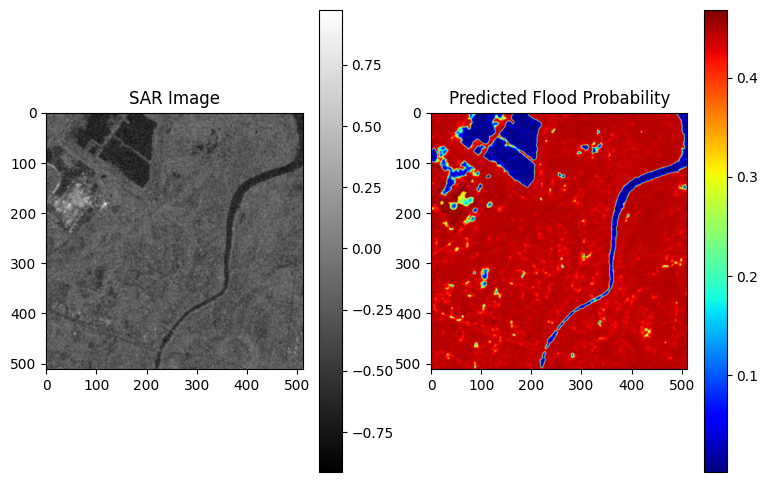

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("unet_flood_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# -----------------------------------------------------------------------------------
# 2) IMAGE LOADING
# -----------------------------------------------------------------------------------
def load_sar_image(image_path, target_size=(512, 512)):
    """
    Load SAR image from file, preprocess it, and resize it to a compatible size.
    """
    with rasterio.open(image_path) as src:
        image = src.read(1).astype(np.float32)
    
    # Apply log transformation and normalize to [-1,1]
    image = 10 * np.log10(image + 1e-6) + 50
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image * 2) - 1
    
    
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    
    image = F.interpolate(image, size=target_size, mode="bilinear", align_corners=False)

    return image

# -----------------------------------------------------------------------------------
# 3) IMPROVED OTSU MASK CREATION
# -----------------------------------------------------------------------------------
def create_ground_truth_from_sar(sar_image_tensor):
    """
    Create a synthetic water mask from the SAR image using Otsu's threshold.
    Then apply morphological operations to reduce noise and improve continuity.
    """
    # Remove batch and channel dimensions and convert to numpy
    sar_image = sar_image_tensor.cpu().squeeze().numpy()
    
    # Compute threshold using Otsu's method
    otsu_thresh = threshold_otsu(sar_image)
    print("Otsu threshold:", otsu_thresh)
    
    # Create binary mask: water is assumed to have values below the threshold
    water_mask = (sar_image < otsu_thresh).astype(np.uint8)
    
    
    selem = disk(3)  
    water_mask = closing(water_mask, selem)
    water_mask = remove_small_objects(water_mask.astype(bool), min_size=64)
    water_mask = remove_small_holes(water_mask, area_threshold=64)
    
    # Convert boolean mask back to uint8 (0 or 1)
    water_mask = water_mask.astype(np.uint8)
    
    return water_mask


image_path = "VH.tif"
test_image = load_sar_image(image_path, target_size=(512, 512))  # Ensure correct input size


synthetic_gt = create_ground_truth_from_sar(test_image)

# -----------------------------------------------------------------------------------
# 5) MODEL INFERENCE
# -----------------------------------------------------------------------------------
with torch.no_grad():
    pred_mask = model(test_image)

# Convert prediction to numpy
pred_mask_np = pred_mask.cpu().squeeze().numpy()

# Threshold the model's output to create a binary flood mask
threshold_value = 0.5  
binary_mask = (pred_mask_np > threshold_value).astype(int)


binary_mask = 1 - binary_mask

# -----------------------------------------------------------------------------------
# 6) EVALUATION (Flood Score & Accuracy)
# -----------------------------------------------------------------------------------
# Flood Score: percentage of non-flooded pixels (value=1) in the inverted mask
non_flooded_fraction = (binary_mask.sum() / binary_mask.size) * 100


# -----------------------------------------------------------------------------------
# 7) VISUALIZATION
# -----------------------------------------------------------------------------------
plt.figure(figsize=(24,6))

# Original SAR Image
plt.subplot(1,5,1)
plt.imshow(test_image.cpu().squeeze(), cmap="gray")
plt.title("SAR Image")
plt.colorbar()

# Predicted Flood Probability
plt.subplot(1,5,2)
plt.imshow(pred_mask_np, cmap="jet")
plt.title("Predicted Flood Probability")
plt.colorbar()



plt.show()


In [3]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

# from unet_model import UNet  # Define or import your UNet model

# -----------------------------------------------------------------------------------
# 1) MODEL LOADING
# -----------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("unet_flood_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# -----------------------------------------------------------------------------------
# 2) IMAGE LOADING FUNCTION
# -----------------------------------------------------------------------------------
def load_sar_image(image_path, target_size=(512, 512)):
    """
    Load SAR image from file, preprocess it, and resize it to a compatible size.
    """
    with rasterio.open(image_path) as src:
        image = src.read(1).astype(np.float32)
    
    # Apply log transformation and normalize to [-1, 1]
    image = 10 * np.log10(image + 1e-6) + 50
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image * 2) - 1
    
    # Convert to tensor and add batch dimension
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
    
    # Resize image to ensure it's a multiple of 32 (suitable for U-Net)
    image = F.interpolate(image, size=target_size, mode="bilinear", align_corners=False)
    return image

# -----------------------------------------------------------------------------------
# 3) IMPROVED OTSU MASK CREATION FUNCTION
# -----------------------------------------------------------------------------------
def create_ground_truth_from_sar(sar_image_tensor):
    """
    Create a synthetic water mask from the SAR image using Otsu's threshold,
    then apply morphological operations to reduce noise and improve continuity.
    """
    # Remove batch and channel dimensions and convert to numpy
    sar_image = sar_image_tensor.cpu().squeeze().numpy()
    
    # Check if the image has sufficient variance
    if np.ptp(sar_image) == 0:
        otsu_thresh = sar_image.flat[0]
        print("Image has no variance, using constant threshold:", otsu_thresh)
    else:
        otsu_thresh = threshold_otsu(sar_image)
        print("Otsu threshold:", otsu_thresh)
    
    # Create binary mask: water is assumed to have values below the threshold
    water_mask = (sar_image < otsu_thresh).astype(np.uint8)
    
    # ------------------ Morphological Post-processing ------------------
    selem = disk(3)  # Structuring element; adjust size as needed
    water_mask = closing(water_mask, selem)
    water_mask = remove_small_objects(water_mask.astype(bool), min_size=64)
    water_mask = remove_small_holes(water_mask, area_threshold=64)
    
    # Convert boolean mask back to uint8 (0 or 1)
    water_mask = water_mask.astype(np.uint8)
    return water_mask

# -----------------------------------------------------------------------------------
# 4) FUNCTION TO PROCESS A SINGLE IMAGE
# -----------------------------------------------------------------------------------
def process_image(image_path, target_size=(512, 512), threshold_value=0.5):
    """
    Process a SAR image: load the image, create a synthetic ground truth water mask,
    perform model inference, and calculate pixel-wise accuracy.
    """
    # Load image and create synthetic ground truth
    test_image = load_sar_image(image_path, target_size=target_size)
    synthetic_gt = create_ground_truth_from_sar(test_image)
    
    # Perform model inference
    with torch.no_grad():
        pred_mask = model(test_image)
    pred_mask_np = pred_mask.cpu().squeeze().numpy()
    
    # Threshold the model's output to create a binary flood mask
    binary_mask = (pred_mask_np > threshold_value).astype(int)
    # Invert the binary mask if needed (to match synthetic_gt convention: water=1)
    binary_mask = 1 - binary_mask

    # Calculate pixel-wise accuracy by comparing predicted mask and synthetic ground truth.
    # Accuracy is defined as the percentage of pixels that are the same in both images.
    accuracy = np.mean(binary_mask == synthetic_gt) * 100
    
    return accuracy, test_image, pred_mask_np, binary_mask, synthetic_gt

# -----------------------------------------------------------------------------------
# 5) ITERATE THROUGH IMAGES IN THE DIRECTORY AND CALCULATE AVERAGE ACCURACY
# -----------------------------------------------------------------------------------
root_dir = "archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/"
accuracies = []
image_paths = []

# Iterate over each subdirectory in root_dir
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # Assume each subdirectory contains a file named "VH.tif"
        image_file = os.path.join(subdir_path, "VH.tif")
        if os.path.exists(image_file):
            image_paths.append(image_file)
            print("Processing:", image_file)
            try:
                accuracy, test_image, pred_mask_np, binary_mask, synthetic_gt = process_image(image_file)
                accuracies.append(accuracy)
                print(f"Accuracy: {accuracy:.2f}%\n")
            except Exception as e:
                print(f"Error processing {image_file}: {e}\n")

if accuracies:
    avg_accuracy = np.mean(accuracies)
    print("Average Accuracy: {:.2f}%".format(avg_accuracy))
else:
    print("No images processed successfully.")






Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0079_2018_12_26/VH.tif
Otsu threshold: -0.22249702
Accuracy: 99.19%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0212_2019_03_18/VH.tif
Otsu threshold: 0.10473877
Accuracy: 74.21%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0331_2019_02_11/VH.tif
Otsu threshold: 0.0109425485
Accuracy: 84.58%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0157_2019_03_25/VH.tif
Otsu threshold: 0.028750539
Accuracy: 74.14%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0261_2019_03_13/VH.tif
Otsu threshold: -0.118745565
Accuracy: 69.73%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0075_2018_12_26/VH.tif
Error processing archive/sen12flood/sen12floods_s

/tmp/ipykernel_5986/581514346.py:32: RuntimeWarning: invalid value encountered in divide
  image = (image - np.min(image)) / (np.max(image) - np.min(image))


Accuracy: 90.71%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_22_2019_04_02/VH.tif
Otsu threshold: 0.03249803
Accuracy: 18.43%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0147_2019_04_01/VH.tif
Otsu threshold: 0.19247508
Accuracy: 86.81%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0186_2019_03_30/VH.tif
Otsu threshold: 0.078681886
Accuracy: 77.43%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0267_2019_03_13/VH.tif
Otsu threshold: -0.055361778
Accuracy: 62.20%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0200_2019_03_18/VH.tif
Otsu threshold: 0.011908948
Accuracy: 86.68%

Processing: archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0330_2019_02_11/VH.tif
Otsu threshold: -0.0050165057
Accur

Looking for label file at: archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/sen12floods_s1_labels_0288_2019_03_08/labels.geojson
Ground truth from archive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/sen12floods_s1_labels_0288_2019_03_08/labels.geojson: NOT FLOODED
Otsu threshold: -0.23833245
Water percentage (Otsu): 73.88%
Classification (Otsu): FLOODED
✗ Otsu classification DOES NOT MATCH ground truth
Model accuracy vs Otsu mask: 73.88%
Model IoU vs Otsu mask: 0.7388


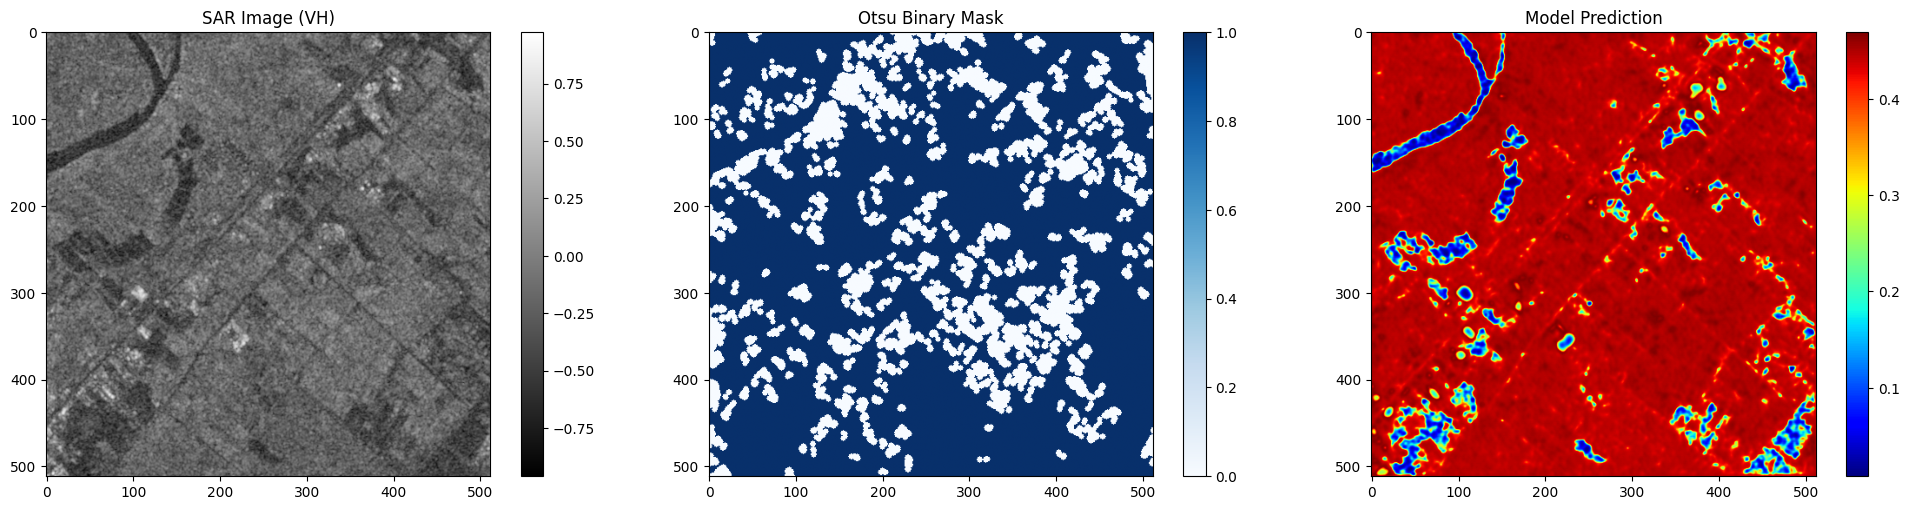

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import json
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

# from unet_model import UNet  # Define or import your UNet model

# -----------------------------------------------------------------------------------
# 1) MODEL LOADING
# -----------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("unet_flood_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# -----------------------------------------------------------------------------------
# 2) IMAGE LOADING
# -----------------------------------------------------------------------------------
def load_sar_image(image_path, target_size=(512, 512)):
    """
    Load SAR image from file, preprocess it, and resize it to a compatible size.
    """
    with rasterio.open(image_path) as src:
        image = src.read(1).astype(np.float32)
    
    # Apply log transformation and normalize to [-1,1]
    image = 10 * np.log10(image + 1e-6) + 50
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image * 2) - 1
    
    # Convert to tensor and add batch dimension
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    # Resize image to ensure it's a multiple of 32 (suitable for U-Net)
    image = F.interpolate(image, size=target_size, mode="bilinear", align_corners=False)

    return image

# -----------------------------------------------------------------------------------
# 3) IMPROVED OTSU MASK CREATION
# -----------------------------------------------------------------------------------
def create_ground_truth_from_sar(sar_image_tensor):
    """
    Create a synthetic water mask from the SAR image using Otsu's threshold.
    Then apply morphological operations to reduce noise and improve continuity.
    """
    # Remove batch and channel dimensions and convert to numpy
    sar_image = sar_image_tensor.cpu().squeeze().numpy()
    
    # Compute threshold using Otsu's method
    otsu_thresh = threshold_otsu(sar_image)
    print("Otsu threshold:", otsu_thresh)
    
    # Create binary mask: water is assumed to have values below the threshold
    water_mask = (sar_image < otsu_thresh).astype(np.uint8)
    
    # ------------------ Morphological Post-processing ------------------
    # 1) Closing to fill small gaps
    selem = disk(3)  # structuring element (adjust size as needed)
    water_mask = closing(water_mask, selem)
    
    # 2) Remove small objects (speckle or noise)
    #    Adjust min_size based on your data scale
    water_mask = remove_small_objects(water_mask.astype(bool), min_size=64)
    
    # 3) Remove small holes within water areas
    #    Adjust area_threshold based on your data
    water_mask = remove_small_holes(water_mask, area_threshold=64)
    
    # Convert boolean mask back to uint8 (0 or 1)
    water_mask = water_mask.astype(np.uint8)
    
    # Calculate water percentage
    water_percentage = (np.sum(water_mask) / water_mask.size) * 100
    print(f"Water percentage (Otsu): {water_percentage:.2f}%")
    
    # Classify as flooded if water percentage is above threshold (e.g., 15%)
    is_flooded = water_percentage > 15.0
    print(f"Classification (Otsu): {'FLOODED' if is_flooded else 'NOT FLOODED'}")
    
    return water_mask, water_percentage, is_flooded

# -----------------------------------------------------------------------------------
# 4) GET GROUND TRUTH FROM LABELS
# -----------------------------------------------------------------------------------
def get_ground_truth_flooding(image_path):
    """
    Get the ground truth flooding label from the corresponding labels.geojson file
    """
    # Parse the path components
    source_dir = os.path.dirname(image_path)
    source_dirname = os.path.basename(source_dir)
    
    # Extract the unique identifier part (e.g., "0288_2019_03_08")
    parts = source_dirname.split("_")
    identifier = "_".join(parts[3:])  # Get parts after "sen12floods_s1_source"
    
    # Create the corresponding label directory name
    label_dirname = f"sen12floods_s1_labels_{identifier}"
    
    # Construct the full path to labels directory
    root_dir = os.path.dirname(os.path.dirname(os.path.dirname(source_dir)))
    labels_dir = os.path.join(root_dir, "sen12floods_s1_labels", "sen12floods_s1_labels", label_dirname)
    
    # Path to labels.geojson
    labels_path = os.path.join(labels_dir, "labels.geojson")
    
    print(f"Looking for label file at: {labels_path}")
    
    if os.path.exists(labels_path):
        with open(labels_path, 'r') as f:
            data = json.load(f)
            is_flooded = data.get("properties", {}).get("FLOODING", None)
            return is_flooded, labels_path
    else:
        print(f"Labels file not found: {labels_path}")
        return None, None

# -----------------------------------------------------------------------------------
# 5) CALCULATE METRICS
# -----------------------------------------------------------------------------------
def calculate_iou(pred_mask, gt_mask):
    """
    Calculate Intersection over Union (IoU) between two binary masks
    
    Args:
        pred_mask: Predicted binary mask
        gt_mask: Ground truth binary mask
        
    Returns:
        iou: Intersection over Union score
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    # Handle edge case of empty union
    if union == 0:
        return 0.0
    
    iou = intersection / union
    return iou

# -----------------------------------------------------------------------------------
# 6) MAIN SCRIPT
# -----------------------------------------------------------------------------------
# Provide the SAR image path
image_path = "archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0288_2019_03_08/VH.tif"
test_image = load_sar_image(image_path, target_size=(512, 512))  # Ensure correct input size

# Get ground truth flooding status
gt_is_flooded, labels_path = get_ground_truth_flooding(image_path)
if gt_is_flooded is not None:
    print(f"Ground truth from {labels_path}: {'FLOODED' if gt_is_flooded else 'NOT FLOODED'}")

# Create improved synthetic ground truth water mask from the SAR image
synthetic_gt, water_percentage, is_flooded_otsu = create_ground_truth_from_sar(test_image)

# Compare Otsu classification with ground truth
if gt_is_flooded is not None:
    if is_flooded_otsu == gt_is_flooded:
        print("✓ Otsu classification MATCHES ground truth")
    else:
        print("✗ Otsu classification DOES NOT MATCH ground truth")

# -----------------------------------------------------------------------------------
# 7) MODEL INFERENCE
# -----------------------------------------------------------------------------------
with torch.no_grad():
    pred_mask = model(test_image)

# Convert prediction to numpy
pred_mask_np = pred_mask.cpu().squeeze().numpy()

# Threshold the model's output to create a binary flood mask
threshold_value = 0.5  
binary_mask = (pred_mask_np > threshold_value).astype(int)
binary_mask = 1 - binary_mask  # Invert if necessary

# Calculate model flood score
non_flooded_fraction = (binary_mask.sum() / binary_mask.size) * 100

# Calculate accuracy against the improved Otsu mask
accuracy = np.mean(binary_mask == synthetic_gt) * 100
print(f"Model accuracy vs Otsu mask: {accuracy:.2f}%")

# Calculate IoU between model prediction and Otsu mask
iou = calculate_iou(binary_mask, synthetic_gt)
print(f"Model IoU vs Otsu mask: {iou:.4f}")

# -----------------------------------------------------------------------------------
# 8) VISUALIZATION
# -----------------------------------------------------------------------------------
plt.figure(figsize=(20, 5))

# Original SAR Image
plt.subplot(1, 3, 1)
plt.imshow(test_image.cpu().squeeze(), cmap="gray")
plt.title("SAR Image (VH)")
plt.colorbar()

# Synthetic Binary Mask (Otsu)
plt.subplot(1, 3, 2)
plt.imshow(synthetic_gt, cmap="Blues")
plt.title(f"Otsu Binary Mask")
plt.colorbar()

# Model Prediction
plt.subplot(1, 3, 3)
plt.imshow(pred_mask_np, cmap="jet")
plt.title(f"Model Prediction")
plt.colorbar()

plt.tight_layout()
plt.show()

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
import json
import glob
from tqdm import tqdm
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

# from unet_model import UNet  # Define or import your UNet model

# -----------------------------------------------------------------------------------
# 1) MODEL LOADING
# -----------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("unet_flood_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode

# -----------------------------------------------------------------------------------
# 2) IMAGE LOADING
# -----------------------------------------------------------------------------------
def load_sar_image(image_path, target_size=(512, 512)):
    """
    Load SAR image from file, preprocess it, and resize it to a compatible size.
    """
    with rasterio.open(image_path) as src:
        image = src.read(1).astype(np.float32)
    
    # Apply log transformation and normalize to [-1,1]
    image = 10 * np.log10(image + 1e-6) + 50
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = (image * 2) - 1
    
    # Convert to tensor and add batch dimension
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

    # Resize image to ensure it's a multiple of 32 (suitable for U-Net)
    image = F.interpolate(image, size=target_size, mode="bilinear", align_corners=False)

    return image

# -----------------------------------------------------------------------------------
# 3) IMPROVED OTSU MASK CREATION
# -----------------------------------------------------------------------------------
def create_ground_truth_from_sar(sar_image_tensor):
    """
    Create a synthetic water mask from the SAR image using Otsu's threshold.
    Then apply morphological operations to reduce noise and improve continuity.
    """
    # Remove batch and channel dimensions and convert to numpy
    sar_image = sar_image_tensor.cpu().squeeze().numpy()
    
    # Compute threshold using Otsu's method
    otsu_thresh = threshold_otsu(sar_image)
    
    # Create binary mask: water is assumed to have values below the threshold
    water_mask = (sar_image < otsu_thresh).astype(np.uint8)
    
    # ------------------ Morphological Post-processing ------------------
    # 1) Closing to fill small gaps
    selem = disk(3)  # structuring element (adjust size as needed)
    water_mask = closing(water_mask, selem)
    
    # 2) Remove small objects (speckle or noise)
    #    Adjust min_size based on your data scale
    water_mask = remove_small_objects(water_mask.astype(bool), min_size=64)
    
    # 3) Remove small holes within water areas
    #    Adjust area_threshold based on your data
    water_mask = remove_small_holes(water_mask, area_threshold=64)
    
    # Convert boolean mask back to uint8 (0 or 1)
    water_mask = water_mask.astype(np.uint8)
    
    # Calculate water percentage
    water_percentage = (np.sum(water_mask) / water_mask.size) * 100
    
    return water_mask, water_percentage

# -----------------------------------------------------------------------------------
# 4) GET GROUND TRUTH FROM LABELS
# -----------------------------------------------------------------------------------
def get_ground_truth_flooding(image_path):
    """
    Get the ground truth flooding label from the corresponding labels.geojson file
    """
    # Parse the path components
    source_dir = os.path.dirname(image_path)
    source_dirname = os.path.basename(source_dir)
    
    # Extract the unique identifier part (e.g., "0288_2019_03_08")
    parts = source_dirname.split("_")
    identifier = "_".join(parts[3:])  # Get parts after "sen12floods_s1_source"
    
    # Create the corresponding label directory name
    label_dirname = f"sen12floods_s1_labels_{identifier}"
    
    # Construct the full path to labels directory
    root_dir = os.path.dirname(os.path.dirname(os.path.dirname(source_dir)))
    labels_dir = os.path.join(root_dir, "sen12floods_s1_labels", "sen12floods_s1_labels", label_dirname)
    
    # Path to labels.geojson
    labels_path = os.path.join(labels_dir, "labels.geojson")
    
    if os.path.exists(labels_path):
        with open(labels_path, 'r') as f:
            data = json.load(f)
            is_flooded = data.get("properties", {}).get("FLOODING", None)
            return is_flooded, labels_path
    else:
        return None, None

# -----------------------------------------------------------------------------------
# 5) CALCULATE METRICS
# -----------------------------------------------------------------------------------
def calculate_iou(pred_mask, gt_mask):
    """
    Calculate Intersection over Union (IoU) between two binary masks
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    # Handle edge case of empty union
    if union == 0:
        return 0.0
    
    iou = intersection / union
    return iou

# -----------------------------------------------------------------------------------
# 6) BATCH EVALUATION OVER MULTIPLE IMAGES
# -----------------------------------------------------------------------------------
def evaluate_dataset(base_dir, max_samples=100):
    """
    Evaluate the model on multiple images from the dataset
    
    Args:
        base_dir: Root directory of the dataset
        max_samples: Maximum number of samples to evaluate (for time constraints)
        
    Returns:
        Dictionary of metrics (accuracy, IoU, etc.)
    """
    # Find VH.tif files in the dataset
    source_pattern = os.path.join(base_dir, "sen12flood", "sen12floods_s1_source", "**", "VH.tif")
    vh_files = glob.glob(source_pattern, recursive=True)
    
    # Limit the number of samples if needed
    if max_samples and len(vh_files) > max_samples:
        vh_files = vh_files[:max_samples]
    
    print(f"Evaluating {len(vh_files)} images...")
    
    # Initialize metrics
    metrics = {
        "total_samples": len(vh_files),
        "valid_samples": 0,
        "total_accuracy": 0.0,
        "total_iou": 0.0,
        "matches": 0,
        "flooded_count": 0,
        "not_flooded_count": 0,
    }
    
    # Process each image
    for i, vh_path in enumerate(tqdm(vh_files)):
        try:
            # Load SAR image
            sar_image = load_sar_image(vh_path)
            
            # Get ground truth flooding status
            gt_is_flooded, _ = get_ground_truth_flooding(vh_path)
            if gt_is_flooded is None:
                continue  # Skip if no ground truth available
            
            # Create Otsu-based water mask
            otsu_mask, water_percentage = create_ground_truth_from_sar(sar_image)
            
            # Run model inference
            with torch.no_grad():
                pred_mask = model(sar_image)
            
            # Convert prediction to binary mask
            pred_mask_np = pred_mask.cpu().squeeze().numpy()
            binary_mask = (pred_mask_np > 0.5).astype(int)
            binary_mask = 1 - binary_mask  # Invert if needed based on your model convention
            
            # Calculate metrics
            accuracy = np.mean(binary_mask == otsu_mask) * 100
            iou = calculate_iou(binary_mask, otsu_mask)
            
            # Update metrics
            metrics["valid_samples"] += 1
            metrics["total_accuracy"] += accuracy
            metrics["total_iou"] += iou
            
            # Count flooded and not flooded images based on ground truth
            if gt_is_flooded:
                metrics["flooded_count"] += 1
            else:
                metrics["not_flooded_count"] += 1
            
            # Keep track of occasional examples for visualization
            if i % 20 == 0:
                # Save a few examples for visualization
                metrics[f"example_{i}"] = {
                    "sar_image": sar_image.cpu().squeeze().numpy(),
                    "otsu_mask": otsu_mask,
                    "model_pred": pred_mask_np,
                    "water_percentage": water_percentage,
                    "gt_is_flooded": gt_is_flooded,
                    "accuracy": accuracy,
                    "iou": iou
                }
                
        except Exception as e:
            print(f"Error processing {vh_path}: {e}")
            continue
    
    # Calculate averages
    if metrics["valid_samples"] > 0:
        metrics["avg_accuracy"] = metrics["total_accuracy"] / metrics["valid_samples"]
        metrics["avg_iou"] = metrics["total_iou"] / metrics["valid_samples"]
    
    return metrics

# -----------------------------------------------------------------------------------
# 7) MAIN SCRIPT
# -----------------------------------------------------------------------------------
# Set the root directory of the dataset
dataset_dir = "archive"

# Evaluate on multiple images
results = evaluate_dataset(dataset_dir, max_samples=50)  # Adjust max_samples as needed

print("==================== DATASET EVALUATION RESULTS ====================")
print(f"Total samples evaluated: {results['valid_samples']}/{results['total_samples']}")
print(f"Average Accuracy: {results['avg_accuracy']:.2f}%")
print(f"Average IoU: {results['avg_iou']:.4f}")
print(f"Flooded images: {results['flooded_count']}")
print(f"Non-flooded images: {results['not_flooded_count']}")
print("===================================================================")



Evaluating 50 images...


 10%|█         | 5/50 [00:15<02:10,  2.91s/it]/tmp/ipykernel_5986/649132767.py:35: RuntimeWarning: invalid value encountered in divide
  image = (image - np.min(image)) / (np.max(image) - np.min(image))


Error processing archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0075_2018_12_26/VH.tif: autodetected range of [nan, nan] is not finite


 34%|███▍      | 17/50 [00:45<01:27,  2.66s/it]

Error processing archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0205_2019_03_13/VH.tif: autodetected range of [nan, nan] is not finite


 38%|███▊      | 19/50 [00:47<01:03,  2.06s/it]

Error processing archive/sen12flood/sen12floods_s1_source/sen12floods_s1_source/sen12floods_s1_source_0244_2019_04_21/VH.tif: autodetected range of [nan, nan] is not finite


100%|██████████| 50/50 [02:08<00:00,  2.58s/it]

==================== DATASET EVALUATION RESULTS ====================
Total samples evaluated: 47/50
Average Accuracy: 77.28%
Average IoU: 0.7728
Flooded images: 20
Non-flooded images: 27
